In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import cv2 as cv
import imghdr

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout

from tensorflow.keras.metrics import Precision , Recall , BinaryAccuracy

from tensorflow.keras.models import load_model

In [2]:
plt.style.use("ggplot")

In [3]:
data_dir = "data"
os.listdir(data_dir)

['ballerina cappuccina',
 'brr brr patapim',
 'lirili larila',
 'tralalero tralala',
 'tung tung tung sahur']

In [4]:
# Removing bad images

valid = ["jpeg" , "jpg" , "bmp" , "png"]
for image_class in os.listdir(data_dir) :
    for image in os.listdir(os.path.join(data_dir , image_class)) :
        image_path = os.path.join(data_dir , image_class , image)
        try :
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in valid :
                os.remove(image_path)
        except Exception as e :
            continue

In [5]:
data = tf.keras.utils.image_dataset_from_directory("data") 

Found 550 files belonging to 5 classes.


In [6]:
data_iterator = data.as_numpy_iterator() 

In [7]:
batch = data_iterator.next() 

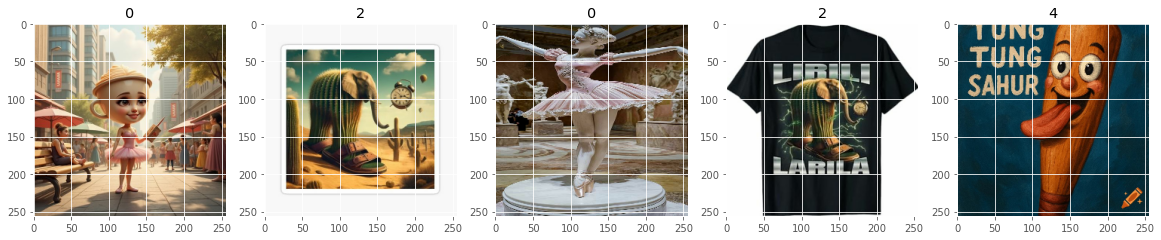

In [8]:
fig , ax = plt.subplots(ncols = 5 , figsize = (20,20))
for idx , img in enumerate(batch[0][:5]) :  
    ax[idx].imshow(img.astype("uint8"))
    ax[idx].title.set_text(batch[1][idx]) # Sets title from batch[1] for each image. 

In [9]:
scaled = data.map(lambda x,y : (x/tf.reduce_max(x) , y)) # Actual Pipeline used for training
scaled_iterator = scaled.as_numpy_iterator() # for loop in the pipeline

In [10]:
batch = scaled_iterator.next()

In [11]:
train_size = int(len(scaled)*0.7)
test_size = int(len(scaled)*0.1)+1
val_size = int(len(scaled)*0.2)+1
# print(train_size)
# print(test_size)
# print(val_size)

In [12]:
train = scaled.take(train_size)
test = scaled.skip(train_size).take(test_size)
val = scaled.skip(train_size+test_size).take(val_size)

## Basic CNN

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16 , (3,3) , 1 , activation = "relu" , input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32 , (3,3) , 1 , activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16 , (3,3) , 1 , activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256 , activation = "relu"))
model.add(Dense(5 , activation = "softmax"))

In [15]:
model.compile(optimizer = "adam" , loss = tf.losses.SparseCategoricalCrossentropy() , metrics = ["accuracy"] )

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [27]:
logdir = "logs_basic"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [18]:
hist = model.fit(train , epochs = 20 , validation_data = val , callbacks = [tensorboard_callback])

12/12 [==============================] - 91s 6s/step - loss: 1.6363 - accuracy: 0.3672 - val_loss: 1.4055 - val_accuracy: 0.3725
Epoch 2/20
12/12 [==============================] - 82s 7s/step - loss: 1.1148 - accuracy: 0.6146 - val_loss: 0.8518 - val_accuracy: 0.7647
Epoch 3/20
12/12 [==============================] - 70s 6s/step - loss: 0.6887 - accuracy: 0.7865 - val_loss: 0.4598 - val_accuracy: 0.9216
Epoch 4/20
12/12 [==============================] - 78s 6s/step - loss: 0.3897 - accuracy: 0.8958 - val_loss: 0.1834 - val_accuracy: 0.9412
Epoch 5/20
12/12 [==============================] - 71s 6s/step - loss: 0.1971 - accuracy: 0.9427 - val_loss: 0.2420 - val_accuracy: 0.9020
Epoch 6/20
12/12 [==============================] - 74s 6s/step - loss: 0.1562 - accuracy: 0.9766 - val_loss: 0.0851 - val_accuracy: 0.9902
Epoch 7/20
12/12 [==============================] - 72s 6s/step - loss: 0.0871 - accuracy: 0.9896 - val_loss: 0.0657 - val_accuracy: 0.9902
Epoch 8/20
12/12 [=============

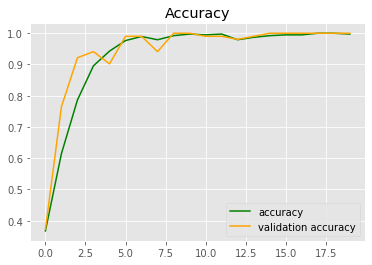

In [54]:
plt.plot(hist.history["accuracy"] , color = "green" , label = "accuracy")
plt.plot(hist.history["val_accuracy"] , color = "orange" , label = "validation accuracy")
plt.title("Accuracy")
plt.legend(loc = "lower right")
plt.show()

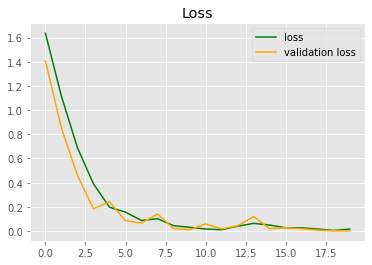

In [53]:
plt.plot(hist.history["loss"] , color = "green" , label = "loss")
plt.plot(hist.history["val_loss"] , color = "orange" , label = "validation loss")
plt.title("Loss")
plt.legend(loc = "upper right")
plt.show()

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
for batch in test.as_numpy_iterator():
    x, y = batch
    
    yhat = model.predict(x)

    y_pred = tf.argmax(yhat, axis=1, output_type=tf.int64)

    y_true = tf.convert_to_tensor(y, dtype=tf.int64)

    # Update metrics
    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)


1/1 [==============================] - 1s 547ms/step


In [31]:
print(f"Precision : {pre.result()} , Recall : {re.result()} , Accuracy : {acc.result()}")

Precision : 1.0 , Recall : 1.0 , Accuracy : 0.390625


[]

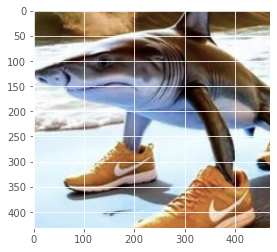

In [48]:
img = cv.imread("tralalero_test.png")
plt.imshow(img)
plt.plot()

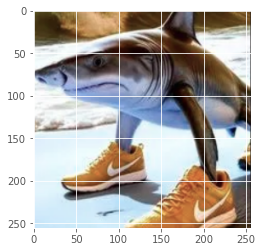

In [49]:
resize = tf.image.resize(img , (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(resize/255 , 0))
ans = list(yhat[0]).index(max(list(yhat[0])))
if (ans == 0) :
    print("Ballerina Cappucina")
elif (ans == 1) :
    print("Brr Brr Patapim")
elif (ans == 2) :
    print("Lirilla Larila")
elif (ans == 3) :
    print("Tralalero Tralala")
elif (ans == 4) :
    print("Tung Tung Tung Tung Tung Tung Tung Sahur")

1/1 [==============================] - 0s 49ms/step
Tralalero Tralala


In [35]:
print(yhat)

[[1.6145487e-01 3.3850863e-04 1.3669729e-02 8.2352269e-01 1.0142381e-03]]


### Saving the model

In [36]:
model.save(os.path.join("models" , "breinrot_classifier_basic.keras"))

In [61]:
breinrot_classifier = load_model(os.path.join("models" , "breinrot_classifier_basic.keras"))